*[Updated 19.12.2021 to use new functionality from the 2021.09 RDKit release]*

Over the last couple of releases we've added a number of RDKit features which allow useage of more advanced substructure query features and more control over the results returned by substructure searches. These include

- `Chem.AdjustQueryProperties()` to tune the results returned by a substructure query
- `rdMolEnumerator.Enumerate()` to enumerate some V3000 mol block query features (as of the 2021.03 release the supported features are variable attachment points and link nodes)
- `rdTautomerQuery.TautomerQuery()` to allow tautomer-insensitive substructures search

In this post I'll show how to use all of those together to do "generalized substructures searching" with the RDKit. Towards the bottom of the post there are a couple of Python functions which can be used in other scripts to make this process easier. I'll also try and figure out a good way to get that into a future RDKit release.

As an example, here's a query: 
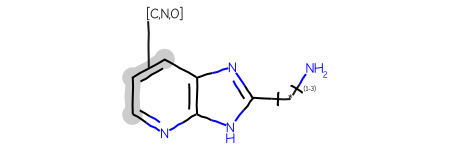
and here are four ChEMBL molecules returned using that query:
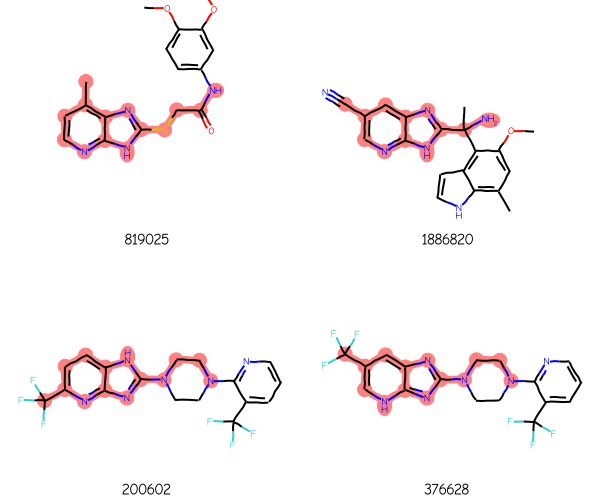

In [1]:
from rdkit import Chem
from rdkit.Chem import rdMolEnumerator
from rdkit.Chem import rdTautomerQuery
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.minFontSize = 10
Draw.SetComicMode(IPythonConsole.drawOptions)
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
import rdkit
print(rdkit.__version__)
import time
print(time.asctime())

2021.09.3
Sun Dec 19 06:14:00 2021


Load a `SubstructLibrary` created using ChEMBL 29. The [`chembl_downloader`](https://github.com/cthoyt/chembl-downloader) Python package is used to abstract away downloading and parsing the ChEMBL SDF data. More information can be found in this blog post: https://cthoyt.com/2021/08/04/taming-chembl-sdf.html.

The code used to construct this is:

```python
from rdkit import RDLogger
from rdkit import Chem
from rdkit.Chem import rdSubstructLibrary
import pickle, time
import gzip
import chembl_downloader

RDLogger.DisableLog("rdApp.warning")
with chembl_downloader.supplier(version="29") as suppl:
    t1=time.time()
    data = []
    for i,mol in enumerate(suppl):
        if not ((i+1)%50000):
            print(f"Processed {i+1} molecules in {(time.time()-t1):.1f} seconds")
        if mol is None or mol.GetNumAtoms()>50:
            continue
        fp = Chem.PatternFingerprint(mol,fpSize=1024,tautomerFingerprints=True)
        smi = Chem.MolToSmiles(mol)
        data.append((smi,fp))
t2=time.time()
pickle.dump(data,open('../data/chembl29_sssdata.pkl','wb+'))
t1=time.time()
mols = rdSubstructLibrary.CachedTrustedSmilesMolHolder()
fps = rdSubstructLibrary.TautomerPatternHolder(1024)
for smi,fp in data:
    mols.AddSmiles(smi)
    fps.AddFingerprint(fp)
library = rdSubstructLibrary.SubstructLibrary(mols,fps)
t2=time.time()
print(f"That took {t2-t1:.2f} seconds. The library has {len(library)} molecules.")
pickle.dump(library,open('../data/chembl29_ssslib.pkl','wb+'))
```

In [2]:
import pickle
with open('./results/chembl29_ssslib.pkl','rb') as inf:
    sslib = pickle.load(inf)
print(f'SubstructLibrary loaded with {len(sslib)} molecules')

SubstructLibrary loaded with 2049078 molecules


# Enumeration

Start with a query including a variable attachment point:

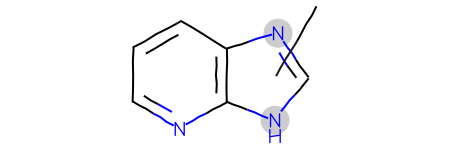

In [3]:
qry = Chem.MolFromMolBlock('''
  Mrv2108 08012107372D          

  0  0  0     0  0            999 V3000
M  V30 BEGIN CTAB
M  V30 COUNTS 11 11 0 0 0
M  V30 BEGIN ATOM
M  V30 1 C -2.4167 7.8734 0 0
M  V30 2 C -3.7503 7.1034 0 0
M  V30 3 C -3.7503 5.5633 0 0
M  V30 4 N -2.4167 4.7933 0 0
M  V30 5 C -1.083 5.5633 0 0
M  V30 6 C -1.083 7.1034 0 0
M  V30 7 N 0.3973 7.5279 0 0
M  V30 8 N 0.3104 5.0377 0 0
M  V30 9 C 1.2585 6.2511 0 0
M  V30 10 * 0.3539 6.2828 0 0
M  V30 11 C 1.5089 8.2833 0 0
M  V30 END ATOM
M  V30 BEGIN BOND
M  V30 1 1 1 2
M  V30 2 2 2 3
M  V30 3 1 3 4
M  V30 4 2 4 5
M  V30 5 1 5 6
M  V30 6 2 1 6
M  V30 7 1 7 6
M  V30 8 1 5 8
M  V30 9 1 8 9
M  V30 10 2 7 9
M  V30 11 1 10 11 ENDPTS=(2 8 7) ATTACH=ANY
M  V30 END BOND
M  V30 END CTAB
M  END
''')
qry

1000 matches


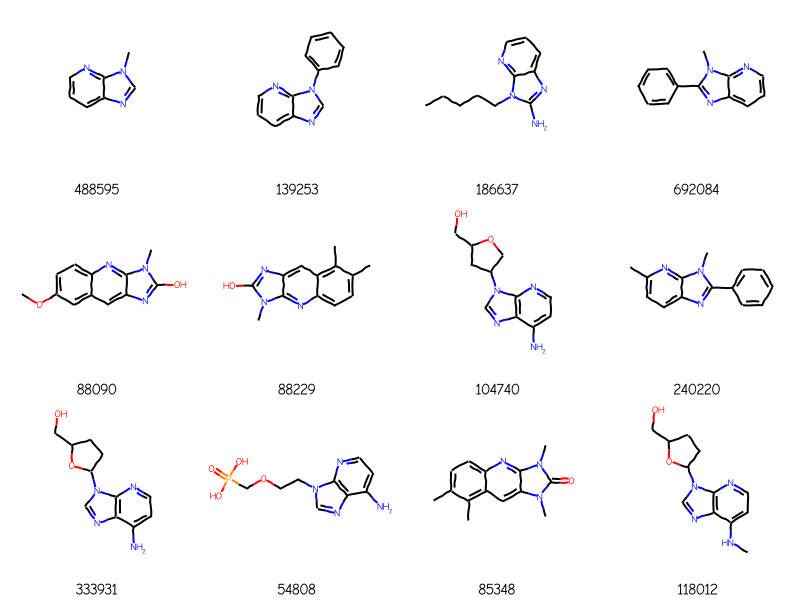

In [4]:
bndl = rdMolEnumerator.Enumerate(qry)
matches = sslib.GetMatches(bndl)
print(f'{len(matches)} matches')
mols = [sslib.GetMol(x) for x in matches]
# sort the molecules by number of atoms and preserve the match ID
sorted_res = sorted(zip(mols,matches),key=lambda x:x[0].GetNumAtoms())
sorted_mols,sorted_matches = zip(*sorted_res)
Draw.MolsToGridImage(sorted_mols[:12],legends=[str(x) for x in sorted_matches],molsPerRow=4)


Those include some addditional rings attached to the core in molecules like 1476, 10083, and 10853. We can prevent that by calling `AdjustQueryProperties()`:

148 matches


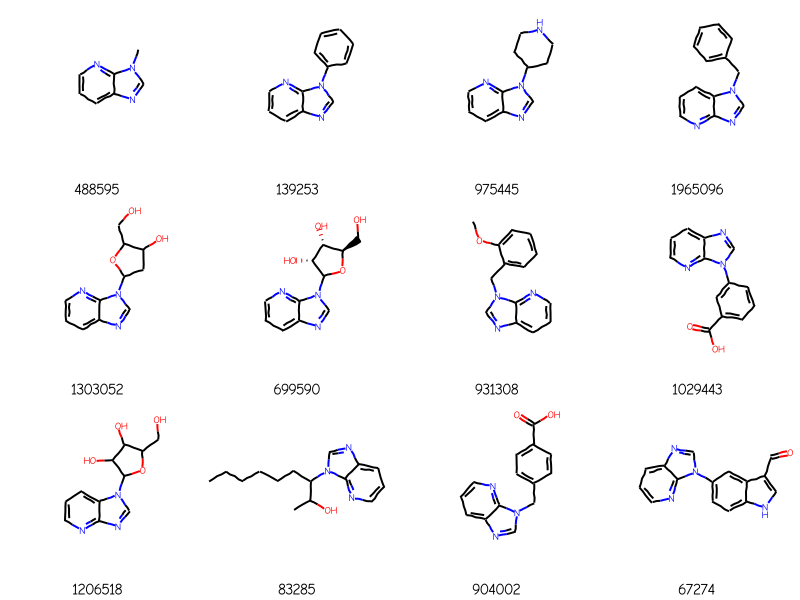

In [5]:
bndl = Chem.MolBundle()
for m in rdMolEnumerator.Enumerate(qry):
    bndl.AddMol(Chem.AdjustQueryProperties(m))
matches = sslib.GetMatches(bndl)
print(f'{len(matches)} matches')
mols = [sslib.GetMol(x) for x in matches]
# sort the molecules by number of atoms and preserve the match ID
sorted_res = sorted(zip(mols,matches),key=lambda x:x[0].GetNumAtoms())
sorted_mols,sorted_matches = zip(*sorted_res)
Draw.MolsToGridImage(sorted_mols[:12],legends=[str(x) for x in sorted_matches],molsPerRow=4)


An aside: this would be more convenient if `AdjustQueryProperties` directly supported passing `MolBundle` objects. That's something for a future version.

Now let's make the query more complex by adding a link node in addition to the variable attachment point:

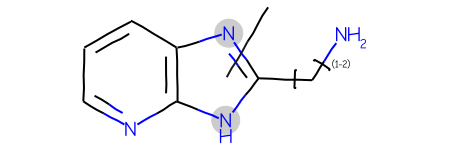

In [6]:
qry = Chem.MolFromMolBlock('''
  Mrv2108 08012108062D          

  0  0  0     0  0            999 V3000
M  V30 BEGIN CTAB
M  V30 COUNTS 13 13 0 0 0
M  V30 BEGIN ATOM
M  V30 1 C -2.4167 7.8734 0 0
M  V30 2 C -3.7503 7.1034 0 0
M  V30 3 C -3.7503 5.5633 0 0
M  V30 4 N -2.4167 4.7933 0 0
M  V30 5 C -1.083 5.5633 0 0
M  V30 6 C -1.083 7.1034 0 0
M  V30 7 N 0.3973 7.5279 0 0
M  V30 8 N 0.3104 5.0377 0 0
M  V30 9 C 1.2585 6.2511 0 0
M  V30 10 * 0.3539 6.2828 0 0
M  V30 11 C 1.5089 8.2833 0 0
M  V30 12 C 2.7975 6.1974 0 0
M  V30 13 N 3.6136 7.5033 0 0
M  V30 END ATOM
M  V30 BEGIN BOND
M  V30 1 1 1 2
M  V30 2 2 2 3
M  V30 3 1 3 4
M  V30 4 2 4 5
M  V30 5 1 5 6
M  V30 6 2 1 6
M  V30 7 1 7 6
M  V30 8 1 5 8
M  V30 9 1 8 9
M  V30 10 2 7 9
M  V30 11 1 10 11 ENDPTS=(2 8 7) ATTACH=ANY
M  V30 12 1 9 12
M  V30 13 1 12 13
M  V30 END BOND
M  V30 LINKNODE 1 2 2 12 9 12 13
M  V30 END CTAB
M  END
''')
qry

193 matches


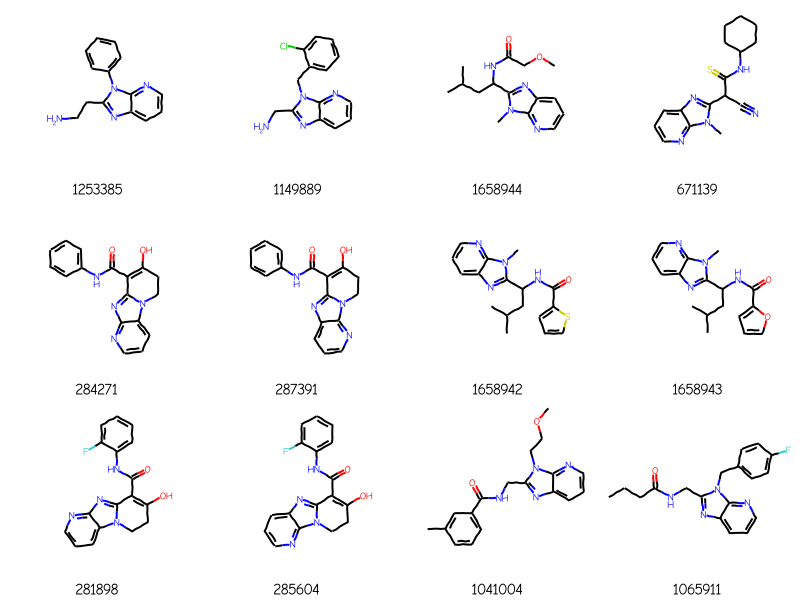

In [7]:
bndl = rdMolEnumerator.Enumerate(qry)
matches = sslib.GetMatches(bndl)
print(f'{len(matches)} matches')
mols = [sslib.GetMol(x) for x in matches]
# sort the molecules by number of atoms and preserve the match ID
sorted_res = sorted(zip(mols,matches),key=lambda x:x[0].GetNumAtoms())
sorted_mols,sorted_matches = zip(*sorted_res)
Draw.MolsToGridImage(sorted_mols[:12],legends=[str(x) for x in sorted_matches],molsPerRow=4)


# Enumeration + tautomer-insensitive queries


Here we will use the RDKit's `TautomerQuery` class to do tautomer-insensitive substructure queries. We start by enumerating the molecules, as above, but then convert each of the results into a `TautomerQuery`

To see what's going on here it helps to have the result molecules all aligned the same way. In order to do that we also need to generate query molecules with aligned coordinates.

In [8]:
from rdkit.Chem import rdFMCS

def getAlignedQueries(qry):
    # generate a conformer for the query if we don't have one already
    if not qry.GetNumConformers():
        rdDepictor.Compute2DCoords(qry)

    bndl = rdMolEnumerator.Enumerate(qry)
    
    # find the MCS of the enumerated molecules:
    mcs = rdFMCS.FindMCS(bndl)
    qmcs = Chem.MolFromSmarts(mcs.smartsString)
    
    # and now adjust the properties, generate coordinates, and create the TautomerQuery
    queries = []
    for q in bndl:
        q = Chem.AdjustQueryProperties(q)
        rdDepictor.GenerateDepictionMatching2DStructure(q,qry,refPatt=qmcs)
        queries.append(rdTautomerQuery.TautomerQuery(q))
    return queries

def drawAlignedMols(mols,qry,legends=None,molsPerRow=4):
    queries = getAlignedQueries(qry)
    for i,m in enumerate(mols):
        for q in queries:
            if q.IsSubstructOf(m):
                rdDepictor.GenerateDepictionMatching2DStructure(m,q.GetTemplateMolecule())
    return Draw.MolsToGridImage(mols,legends=legends,molsPerRow=molsPerRow)

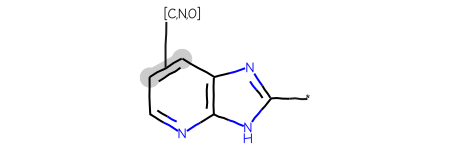

In [9]:
qry = Chem.MolFromMolBlock('''
  Mrv2108 08012108222D          

  0  0  0     0  0            999 V3000
M  V30 BEGIN CTAB
M  V30 COUNTS 12 12 0 0 0
M  V30 BEGIN ATOM
M  V30 1 C -2.4167 7.8734 0 0
M  V30 2 C -3.7503 7.1034 0 0
M  V30 3 C -3.7503 5.5633 0 0
M  V30 4 N -2.4167 4.7933 0 0
M  V30 5 C -1.083 5.5633 0 0
M  V30 6 C -1.083 7.1034 0 0
M  V30 7 N 0.3973 7.5279 0 0
M  V30 8 N 0.3104 5.0377 0 0
M  V30 9 C 1.2585 6.2511 0 0
M  V30 10 * -3.0835 7.4884 0 0
M  V30 11 [C,N,O] -3.0835 9.7984 0 0
M  V30 12 * 2.7975 6.1974 0 0
M  V30 END ATOM
M  V30 BEGIN BOND
M  V30 1 1 1 2
M  V30 2 2 2 3
M  V30 3 1 3 4
M  V30 4 2 4 5
M  V30 5 1 5 6
M  V30 6 2 1 6
M  V30 7 1 7 6
M  V30 8 1 5 8
M  V30 9 1 8 9
M  V30 10 2 7 9
M  V30 11 1 10 11 ENDPTS=(2 2 1) ATTACH=ANY
M  V30 12 1 9 12
M  V30 END BOND
M  V30 END CTAB
M  END
''')
qry

Start by doing a tautomer-sensitive query to see how many results we get:

276 matches


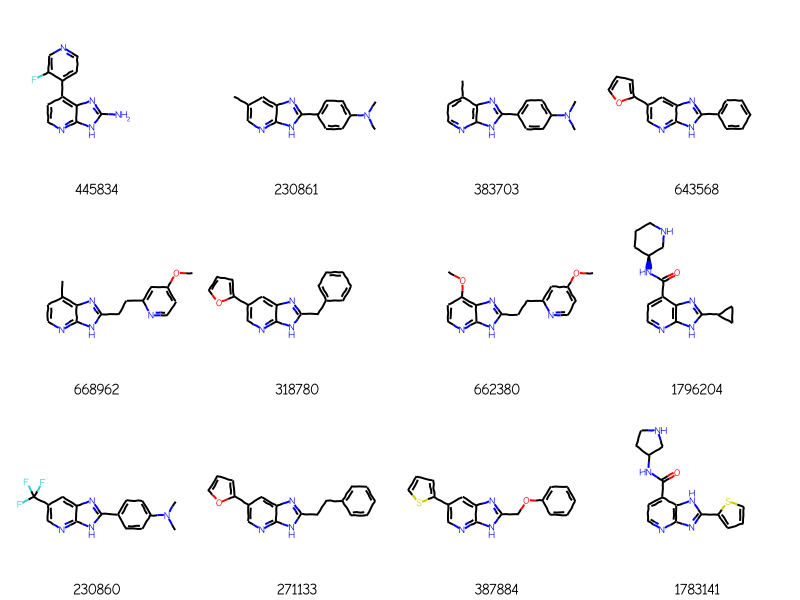

In [10]:
bndl = rdMolEnumerator.Enumerate(qry)
matches = []
for m in bndl:
    m = Chem.AdjustQueryProperties(m)
    matches.extend(sslib.GetMatches(m))
print(f'{len(matches)} matches')
mols = [sslib.GetMol(x) for x in matches]

# sort the molecules by number of atoms and preserve the match ID
sorted_res = sorted(zip(mols,matches),key=lambda x:x[0].GetNumAtoms())
sorted_mols,sorted_matches = zip(*sorted_res)
drawAlignedMols(sorted_mols[:12],qry,[str(x) for x in sorted_matches])

Now do the tautomer-insensitive version of that and show just the new molecules

288 matches, 12 are non-overlapping


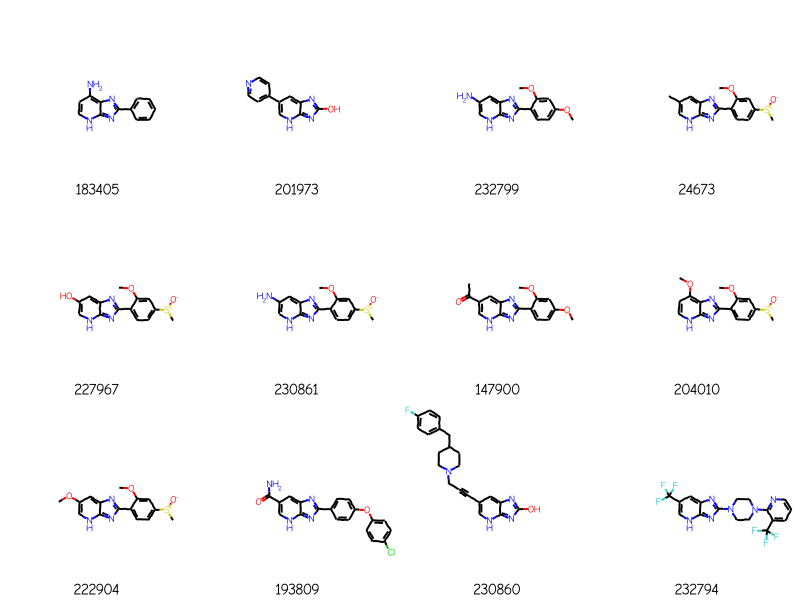

In [11]:
bndl = rdMolEnumerator.Enumerate(qry)
matches2 = []
for m in bndl:
    m = Chem.AdjustQueryProperties(m)
    tqry = rdTautomerQuery.TautomerQuery(m)
    matches2.extend(sslib.GetMatches(tqry))
extras = set(matches2).difference(matches)
print(f'{len(matches2)} matches, {len(extras)} are non-overlapping')
mols = [sslib.GetMol(x) for x in extras]
# sort the molecules by number of atoms and preserve the match ID
sorted_res = sorted(zip(mols,matches),key=lambda x:x[0].GetNumAtoms())
sorted_mols,sorted_matches = zip(*sorted_res)
drawAlignedMols(sorted_mols[:12],qry,[str(x) for x in sorted_matches])

# Bring it all together

Now let's put that all together in one function and include the information required to do atom highlighting in the structure drawings

In [12]:
from rdkit.Chem import rdFMCS
from rdkit.Chem import rdTautomerQuery

# this function does the enumeration of the queries
def getAlignedQueries(qry,tautomerInsensitive=True):
    if not qry.GetNumConformers():
        rdDepictor.Compute2DCoords(qry)
    bndl = rdMolEnumerator.Enumerate(qry)
    
    # find the MCS of the enumerated molecules:
    mcs = rdFMCS.FindMCS(bndl)
    qmcs = Chem.MolFromSmarts(mcs.smartsString)
    
    # and now adjust the properties, generate coordinates, and create the TautomerQuery
    queries = []
    for q in bndl:
        q = Chem.AdjustQueryProperties(q)
        rdDepictor.GenerateDepictionMatching2DStructure(q,qry,refPatt=qmcs)
        if tautomerInsensitive:
            q = rdTautomerQuery.TautomerQuery(q)
        queries.append(q)
    return queries


def generalizedSubstructureSearch(query,sslib,tautomerInsensitive=True,alignResults=True,
                                  maxResults=1000):
    queries = getAlignedQueries(query,tautomerInsensitive=tautomerInsensitive)
    matches = []
    for q in queries:
        matches.extend(sslib.GetMatches(q,maxResults=maxResults))
    tmols = [(x,sslib.GetMol(x)) for x in matches]
    mols = []
    for idx,mol in sorted(tmols,key=lambda x:x[1].GetNumAtoms()):
        match = None
        if(alignResults):
            for q in queries:
                if tautomerInsensitive:
                    match = q.GetSubstructMatch(mol)
                    if match:
                        rdDepictor.GenerateDepictionMatching2DStructure(mol,q.GetTemplateMolecule())
                        break
                else:
                    match = mol.GetSubstructMatch(q)
                    if match:
                        rdDepictor.GenerateDepictionMatching2DStructure(mol,q)
                        break
                
        mols.append((idx,mol,match))
        if len(mols)>=maxResults:
            break
    return mols
    

288 results


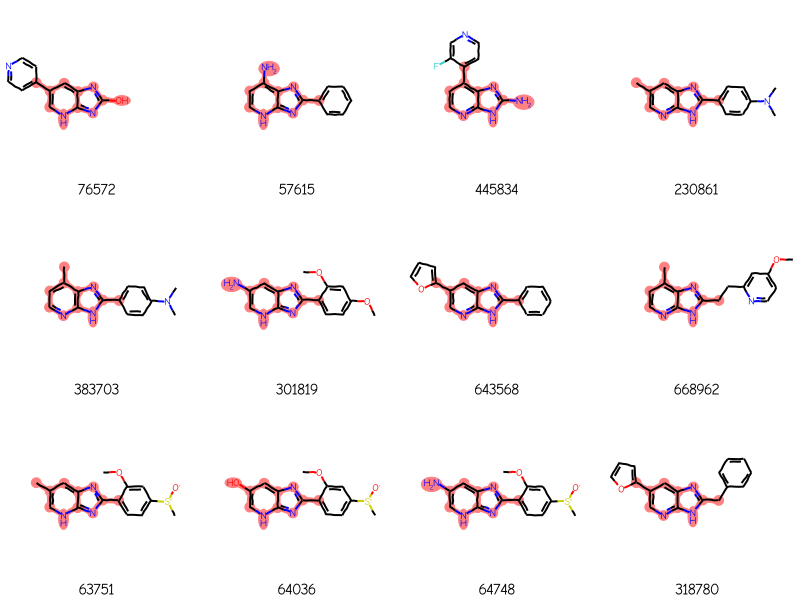

In [13]:
res = generalizedSubstructureSearch(qry,sslib)
ids,mols,matchAtoms = zip(*res)
print(f'{len(mols)} results')
Draw.MolsToGridImage(mols[:12],legends=[str(x) for x in ids],highlightAtomLists=matchAtoms,
                     molsPerRow=4)

276 results


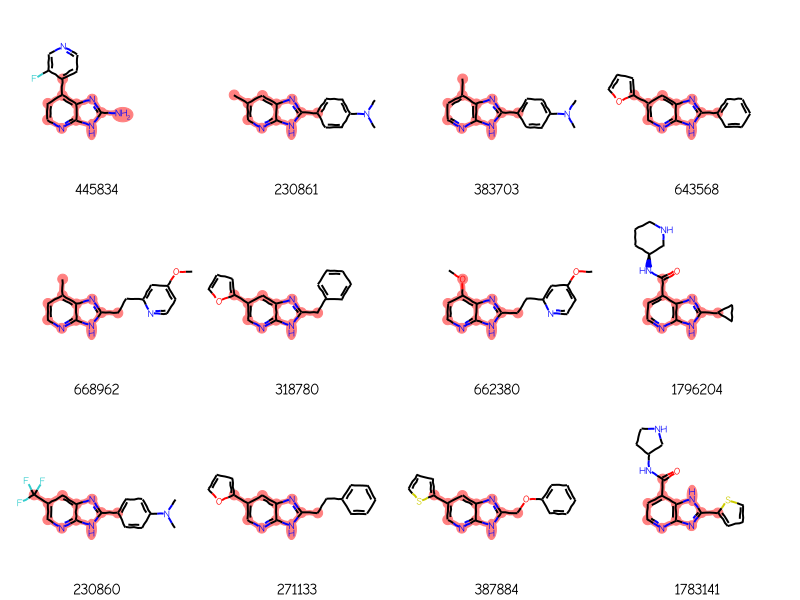

In [14]:
res = generalizedSubstructureSearch(qry,sslib,tautomerInsensitive=False)
ids,mols,matchAtoms = zip(*res)
print(f'{len(mols)} results')
Draw.MolsToGridImage(mols[:12],legends=[str(x) for x in ids],highlightAtomLists=matchAtoms,
                     molsPerRow=4)

Last example, link nodes + variable attachment + tautomer enumeration

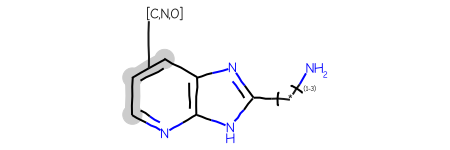

In [15]:
qry = Chem.MolFromMolBlock('''
  Mrv2108 08032106392D          

  0  0  0     0  0            999 V3000
M  V30 BEGIN CTAB
M  V30 COUNTS 13 13 0 0 0
M  V30 BEGIN ATOM
M  V30 1 C -2.4167 7.8734 0 0
M  V30 2 C -3.7503 7.1034 0 0
M  V30 3 C -3.7503 5.5633 0 0
M  V30 4 N -2.4167 4.7933 0 0
M  V30 5 C -1.083 5.5633 0 0
M  V30 6 C -1.083 7.1034 0 0
M  V30 7 N 0.3973 7.5279 0 0
M  V30 8 N 0.3104 5.0377 0 0
M  V30 9 C 1.2585 6.2511 0 0
M  V30 10 * -3.0835 7.4884 0 0
M  V30 11 [C,N,O] -3.0835 9.7984 0 0
M  V30 12 * 2.7975 6.1974 0 0
M  V30 13 N 3.6136 7.5033 0 0
M  V30 END ATOM
M  V30 BEGIN BOND
M  V30 1 1 1 2
M  V30 2 2 2 3
M  V30 3 1 3 4
M  V30 4 2 4 5
M  V30 5 1 5 6
M  V30 6 2 1 6
M  V30 7 1 7 6
M  V30 8 1 5 8
M  V30 9 1 8 9
M  V30 10 2 7 9
M  V30 11 1 10 11 ENDPTS=(3 3 2 1) ATTACH=ANY
M  V30 12 1 9 12
M  V30 13 1 12 13
M  V30 END BOND
M  V30 LINKNODE 1 3 2 12 9 12 13
M  V30 END CTAB
M  END
''')
qry

24 results


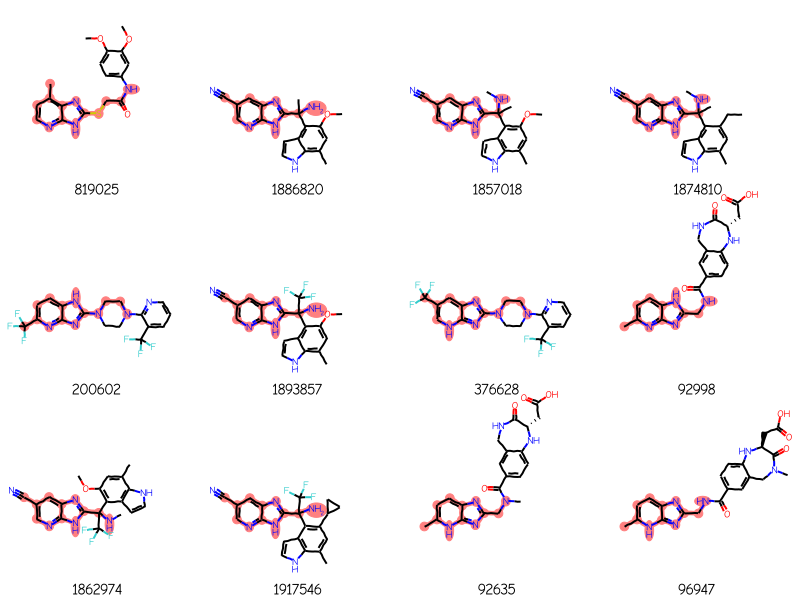

In [16]:
res = generalizedSubstructureSearch(qry,sslib)
ids,mols,matchAtoms = zip(*res)
print(f'{len(mols)} results')
Draw.MolsToGridImage(mols[:12],legends=[str(x) for x in ids],highlightAtomLists=matchAtoms,
                     molsPerRow=4)

Image for the blog post summary:

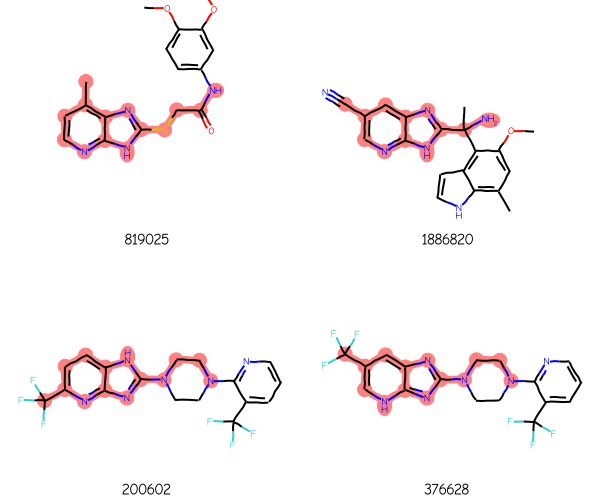

In [17]:
keep = [0,1,4,6]
ids,mols,matchAtoms = zip(*[res[x] for x in keep])
Draw.MolsToGridImage(mols[:12],legends=[str(x) for x in ids],highlightAtomLists=matchAtoms,
                    molsPerRow=2,subImgSize=(300,250))